In [2]:
import pandas as pd

In [3]:
# Load the datas
sp500 = pd.read_csv('sp500wiki.csv')
data = pd.read_csv('data.csv')

In [4]:
print(sp500.head())
print(data.head())
print(sp500.columns)
print(data.columns)

   Unnamed: 0 Symbol     Security SEC filings  GICS Sector  \
0           0    MMM           3M     reports  Industrials   
1           1    AOS  A. O. Smith     reports  Industrials   
2           2    ABT       Abbott     reports  Health Care   
3           3   ABBV       AbbVie     reports  Health Care   
4           4   ABMD      Abiomed     reports  Health Care   

          GICS Sub-Industry    Headquarters Location Date first added  \
0  Industrial Conglomerates    Saint Paul, Minnesota       1976-08-09   
1         Building Products     Milwaukee, Wisconsin       2017-07-26   
2     Health Care Equipment  North Chicago, Illinois       1964-03-31   
3           Pharmaceuticals  North Chicago, Illinois       2012-12-31   
4     Health Care Equipment   Danvers, Massachusetts       2018-05-31   

       CIK      Founded Wikidata ID  
0    66740         1902     Q159433  
1    91142         1916    Q4648219  
2     1800         1888     Q306764  
3  1551152  2013 (1888)   Q14662364 

In [5]:
# Merge the datasets on the 'Symbol' column
merged_data = pd.merge(data, sp500, on='Symbol', how='inner')
print(merged_data.head())

         Date        Open        High         Low       Close   Adj Close  \
0  2020-09-30  160.929993  163.100006  158.610001  160.179993  150.921692   
1  2020-10-01  160.669998  161.899994  157.720001  158.789993  149.612045   
2  2020-10-02  156.470001  161.940002  156.250000  160.360001  151.091309   
3  2020-10-05  162.250000  163.500000  161.759995  162.750000  153.343170   
4  2020-10-06  163.440002  165.699997  161.830002  162.229996  152.853195   

      Volume Symbol Security_x GICS Sector_x  ... Unnamed: 0  Security_y  \
0  3056900.0    MMM         3M   Industrials  ...          0          3M   
1  1989100.0    MMM         3M   Industrials  ...          0          3M   
2  1768600.0    MMM         3M   Industrials  ...          0          3M   
3  1457000.0    MMM         3M   Industrials  ...          0          3M   
4  2021900.0    MMM         3M   Industrials  ...          0          3M   

   SEC filings  GICS Sector_y       GICS Sub-Industry_y  \
0      reports    Ind

In [6]:
# Checking for duplicate and null values in the datasets
duplicates = merged_data.duplicated()
print("Number of duplicate rows:", duplicates.sum())
missing_values = merged_data.isnull().sum()
print("Missing values in each column:\n", missing_values)

Number of duplicate rows: 0
Missing values in each column:
 Date                                 0
Open                                 0
High                                 0
Low                                  0
Close                                0
Adj Close                            0
Volume                               0
Symbol                               0
Security_x                           0
GICS Sector_x                        0
GICS Sub-Industry_x                  0
News - All News Volume             520
News - Volume                      520
News - Positive Sentiment          520
News - Negative Sentiment          520
News - New Products                520
News - Layoffs                     520
News - Analyst Comments            520
News - Stocks                      520
News - Dividends                   520
News - Corporate Earnings          520
News - Mergers & Acquisitions      520
News - Store Openings              520
News - Product Recalls             520
News

In [7]:
merged_data.fillna(0, inplace=True)

In [8]:
merged_data.to_csv('merged_data.csv', index=False)

In [9]:
print(merged_data.columns)

Index(['Date', 'Open', 'High', 'Low', 'Close', 'Adj Close', 'Volume', 'Symbol',
       'Security_x', 'GICS Sector_x', 'GICS Sub-Industry_x',
       'News - All News Volume', 'News - Volume', 'News - Positive Sentiment',
       'News - Negative Sentiment', 'News - New Products', 'News - Layoffs',
       'News - Analyst Comments', 'News - Stocks', 'News - Dividends',
       'News - Corporate Earnings', 'News - Mergers & Acquisitions',
       'News - Store Openings', 'News - Product Recalls',
       'News - Adverse Events', 'News - Personnel Changes',
       'News - Stock Rumors', 'Unnamed: 0', 'Security_y', 'SEC filings',
       'GICS Sector_y', 'GICS Sub-Industry_y', 'Headquarters Location',
       'Date first added', 'CIK', 'Founded', 'Wikidata ID'],
      dtype='object')


In [10]:
# Creating a Overall Sentiment Score for that particular day
merged_data['Sentiment_Score'] = merged_data['News - Positive Sentiment'] - merged_data['News - Negative Sentiment']

In [11]:
# Creating binary indicators for each event type
event_columns = [
    'News - New Products', 'News - Layoffs', 'News - Analyst Comments',
    'News - Dividends', 'News - Corporate Earnings', 'News - Mergers & Acquisitions',
    'News - Store Openings', 'News - Product Recalls', 'News - Adverse Events',
    'News - Personnel Changes', 'News - Stock Rumors'
]

for column in event_columns:
    merged_data[column + '_Indicator'] = merged_data[column].apply(lambda x: 1 if x > 0 else 0)

In [12]:
# Creating Weighted Sentiment for Each Day
merged_data['Weighted_Sentiment'] = merged_data['Sentiment_Score'] * merged_data['News - Volume']

In [13]:
# Calculating moving averages for 5 Days and 10 Days
merged_data['MA_5'] = merged_data['Close'].rolling(window=5).mean()
merged_data['MA_10'] = merged_data['Close'].rolling(window=10).mean()

# Calculate Relative Strength Index (RSI)
def calculate_rsi(data, window=14):
    delta = data.diff()
    gain = (delta.where(delta > 0, 0)).rolling(window=window).mean()
    loss = (-delta.where(delta < 0, 0)).rolling(window=window).mean()
    rs = gain / loss
    rsi = 100 - (100 / (1 + rs))
    return rsi

merged_data['RSI'] = calculate_rsi(merged_data['Close'])

In [14]:
sector_sentiment = merged_data.groupby('GICS Sector_x')['Sentiment_Score'].mean().reset_index()
print(sector_sentiment)

             GICS Sector_x  Sentiment_Score
0   Communication Services         4.956770
1   Consumer Discretionary         3.427034
2         Consumer Staples         0.392071
3                   Energy        -0.516359
4               Financials        -0.408885
5              Health Care        -1.350052
6              Industrials        -2.315760
7   Information Technology         2.265420
8                Materials        -0.026401
9              Real Estate        -0.537339
10               Utilities        -0.236863


In [15]:
print(merged_data.columns)

Index(['Date', 'Open', 'High', 'Low', 'Close', 'Adj Close', 'Volume', 'Symbol',
       'Security_x', 'GICS Sector_x', 'GICS Sub-Industry_x',
       'News - All News Volume', 'News - Volume', 'News - Positive Sentiment',
       'News - Negative Sentiment', 'News - New Products', 'News - Layoffs',
       'News - Analyst Comments', 'News - Stocks', 'News - Dividends',
       'News - Corporate Earnings', 'News - Mergers & Acquisitions',
       'News - Store Openings', 'News - Product Recalls',
       'News - Adverse Events', 'News - Personnel Changes',
       'News - Stock Rumors', 'Unnamed: 0', 'Security_y', 'SEC filings',
       'GICS Sector_y', 'GICS Sub-Industry_y', 'Headquarters Location',
       'Date first added', 'CIK', 'Founded', 'Wikidata ID', 'Sentiment_Score',
       'News - New Products_Indicator', 'News - Layoffs_Indicator',
       'News - Analyst Comments_Indicator', 'News - Dividends_Indicator',
       'News - Corporate Earnings_Indicator',
       'News - Mergers & Acquisit

In [16]:
# Drop rows with NaN values
merged_data.dropna(inplace=True)
print(merged_data.head())

          Date        Open        High         Low       Close   Adj Close  \
13  2020-10-19  171.020004  172.350006  168.869995  169.550003  159.750107   
14  2020-10-20  170.500000  173.190002  169.990005  170.949997  161.069199   
15  2020-10-21  170.339996  172.110001  169.070007  169.169998  159.392090   
16  2020-10-22  169.639999  170.990005  168.389999  170.710007  160.843079   
17  2020-10-23  171.919998  172.179993  169.020004  169.800003  159.985687   

       Volume Symbol Security_x GICS Sector_x  ...  \
13  1909900.0    MMM         3M   Industrials  ...   
14  1813000.0    MMM         3M   Industrials  ...   
15  1511100.0    MMM         3M   Industrials  ...   
16  1663200.0    MMM         3M   Industrials  ...   
17  2137500.0    MMM         3M   Industrials  ...   

   News - Mergers & Acquisitions_Indicator  News - Store Openings_Indicator  \
13                                       1                                0   
14                                       0      

In [17]:
# Display all column names in the filtered data DataFrame
print(merged_data.columns)

Index(['Date', 'Open', 'High', 'Low', 'Close', 'Adj Close', 'Volume', 'Symbol',
       'Security_x', 'GICS Sector_x', 'GICS Sub-Industry_x',
       'News - All News Volume', 'News - Volume', 'News - Positive Sentiment',
       'News - Negative Sentiment', 'News - New Products', 'News - Layoffs',
       'News - Analyst Comments', 'News - Stocks', 'News - Dividends',
       'News - Corporate Earnings', 'News - Mergers & Acquisitions',
       'News - Store Openings', 'News - Product Recalls',
       'News - Adverse Events', 'News - Personnel Changes',
       'News - Stock Rumors', 'Unnamed: 0', 'Security_y', 'SEC filings',
       'GICS Sector_y', 'GICS Sub-Industry_y', 'Headquarters Location',
       'Date first added', 'CIK', 'Founded', 'Wikidata ID', 'Sentiment_Score',
       'News - New Products_Indicator', 'News - Layoffs_Indicator',
       'News - Analyst Comments_Indicator', 'News - Dividends_Indicator',
       'News - Corporate Earnings_Indicator',
       'News - Mergers & Acquisit

In [19]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split, TimeSeriesSplit, GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix, roc_curve, auc, mean_squared_error, r2_score
from sklearn.linear_model import LinearRegression
from imblearn.over_sampling import SMOTE
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
import seaborn as sns
import matplotlib.pyplot as plt
import shap


# Selecting relevant features for the machine learning models 
selected_features = [
    'Symbol', 'Close', 'Adj Close', 'Volume', 'Sentiment_Score', 'Weighted_Sentiment',
    'MA_5', 'MA_10', 'RSI', 'News - Analyst Comments_Indicator',
    'News - Corporate Earnings_Indicator', 'News - Mergers & Acquisitions_Indicator',
    'GICS Sector_x', 'Date'
]


data_selected = merged_data[selected_features].copy()
data_selected['Date'] = pd.to_datetime(data_selected['Date'])


data_selected['Day_of_Week'] = data_selected['Date'].dt.dayofweek
data_selected['Month'] = data_selected['Date'].dt.month

# Creating lag features for the Close, Volume and Sentiment Score 
lag_features = ['Close', 'Volume', 'Sentiment_Score']
for feature in lag_features:
    for lag in [1, 2]:
        data_selected[f'{feature}_Lag{lag}'] = data_selected.groupby('Symbol')[feature].shift(lag)

# Calculating price change and direction (Upward  Trend(1) and Downward Trend(0))
data_selected['Price_Change'] = data_selected.groupby('Symbol')['Close'].pct_change()
data_selected['Direction'] = np.where(data_selected['Price_Change'] > 0, 1, 0)

# Drop NaN values and encode categorical variables
data_selected.dropna(inplace=True)
data_selected = pd.get_dummies(data_selected, columns=['GICS Sector_x', 'Symbol'], drop_first=True)

# Filtering for specific four stocks
symbols_to_keep = ['MMM', 'AAPL', 'GOOGL', 'AMZN']
symbol_columns = [f'Symbol_{symbol}' for symbol in symbols_to_keep if f'Symbol_{symbol}' in data_selected.columns]
data_selected = data_selected[data_selected[symbol_columns].any(axis=1)]

# Normalize features
scaler = StandardScaler()
features_to_scale = ['Close', 'Adj Close', 'Volume', 'Sentiment_Score', 'Weighted_Sentiment', 'MA_5', 'MA_10', 'RSI'] + \
                    [f'{feature}_Lag{i}' for feature in lag_features for i in [1, 2]]
data_selected[features_to_scale] = scaler.fit_transform(data_selected[features_to_scale])


data_selected = data_selected.sort_values('Date')
unique_dates = data_selected['Date'].unique()
train_dates, test_dates = train_test_split(unique_dates, test_size=0.2, shuffle=False)

X_train = data_selected[data_selected['Date'].isin(train_dates)].drop(['Date', 'Price_Change', 'Direction'], axis=1)
X_test = data_selected[data_selected['Date'].isin(test_dates)].drop(['Date', 'Price_Change', 'Direction'], axis=1)
y_train = data_selected[data_selected['Date'].isin(train_dates)]['Direction']
y_test = data_selected[data_selected['Date'].isin(test_dates)]['Direction']

# Applying SMOTE to balance the class
smote = SMOTE(random_state=42)
X_train_resampled, y_train_resampled = smote.fit_resample(X_train, y_train)

print("Resampled class distribution:")
print(y_train_resampled.value_counts())
print("Dataset shape:", X_train.shape)
print("Class distribution:")
print(y_train.value_counts(normalize=True))

/usr/local/lib/python3.10/dist-packages/dask/dataframe/__init__.py:42: FutureWarning: 
Dask dataframe query planning is disabled because dask-expr is not installed.

You can install it with `pip install dask[dataframe]` or `conda install dask`.
This will raise in a future version.

  warnings.warn(msg, FutureWarning)


Resampled class distribution:
Direction
1    1019
0    1019
Name: count, dtype: int64
Dataset shape: (1744, 523)
Class distribution:
Direction
0    0.584289
1    0.415711
Name: proportion, dtype: float64


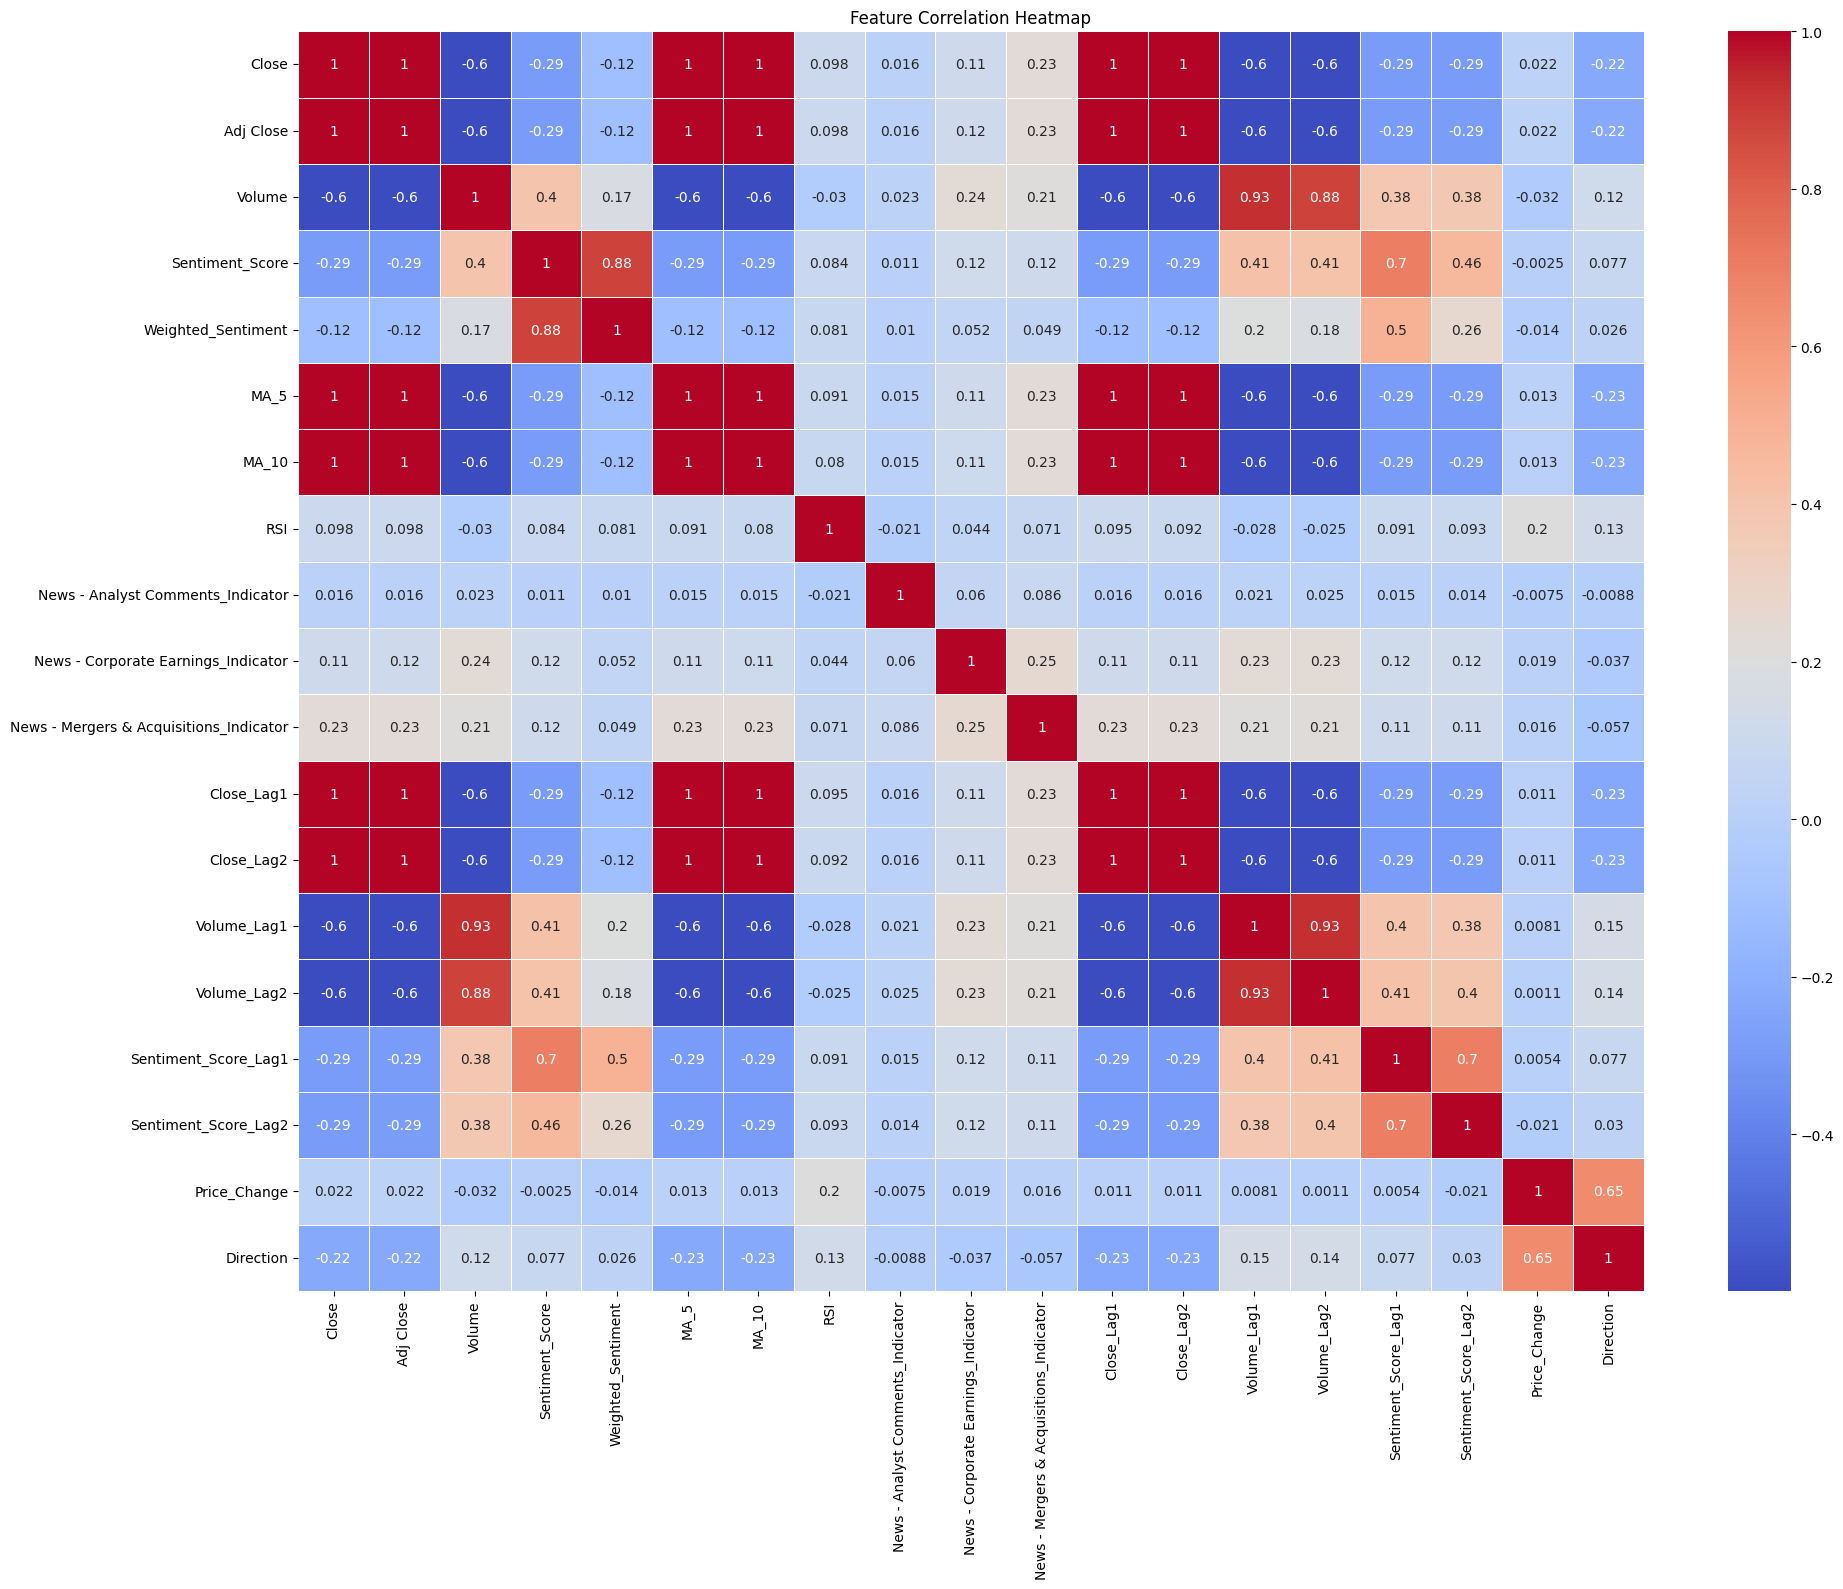

Performing GridSearchCV for RandomForestClassifier...
Best parameters for RandomForestClassifier:
{'max_depth': None, 'min_samples_split': 2, 'n_estimators': 200}

RandomForest Test Accuracy: 0.675

RandomForest Classification Report:
              precision    recall  f1-score   support

           0       0.69      0.85      0.76       267
           1       0.64      0.40      0.49       173

    accuracy                           0.68       440
   macro avg       0.66      0.63      0.63       440
weighted avg       0.67      0.68      0.66       440


Random Forest - Top 10 Most Important Features:
                 feature  importance
13            Close_Lag1    0.077202
17  Sentiment_Score_Lag1    0.073658
6                  MA_10    0.071084
5                   MA_5    0.070801
15           Volume_Lag1    0.069420
7                    RSI    0.068610
0                  Close    0.064648
1              Adj Close    0.063639
14            Close_Lag2    0.062736
2                 V

/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [01:34:49] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)



XGBoost Test Accuracy: 0.8136363636363636

XGBoost Classification Report:
              precision    recall  f1-score   support

           0       0.85      0.84      0.85       267
           1       0.76      0.77      0.77       173

    accuracy                           0.81       440
   macro avg       0.80      0.81      0.81       440
weighted avg       0.81      0.81      0.81       440


XGBoost - Top 10 Most Important Features:
                      feature  importance
6                       MA_10    0.114421
24  GICS Sector_x_Industrials    0.080511
13                 Close_Lag1    0.068280
0                       Close    0.062792
7                         RSI    0.060871
14                 Close_Lag2    0.054676
18       Sentiment_Score_Lag2    0.051787
1                   Adj Close    0.049262
17       Sentiment_Score_Lag1    0.048609
16                Volume_Lag2    0.047860

Training LightGBM...
[LightGBM] [Warning] Found whitespace in feature_names, replace with un

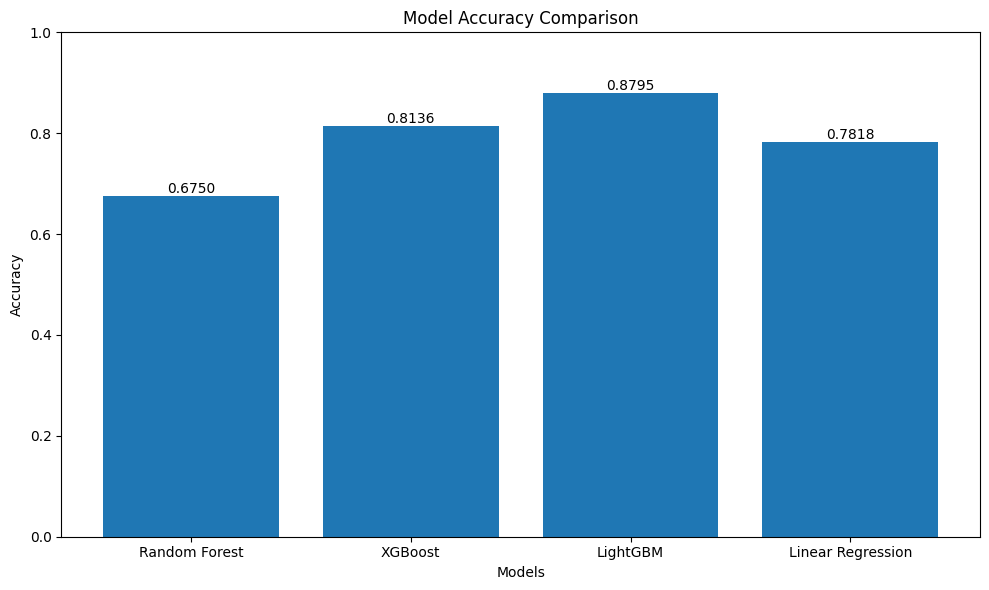

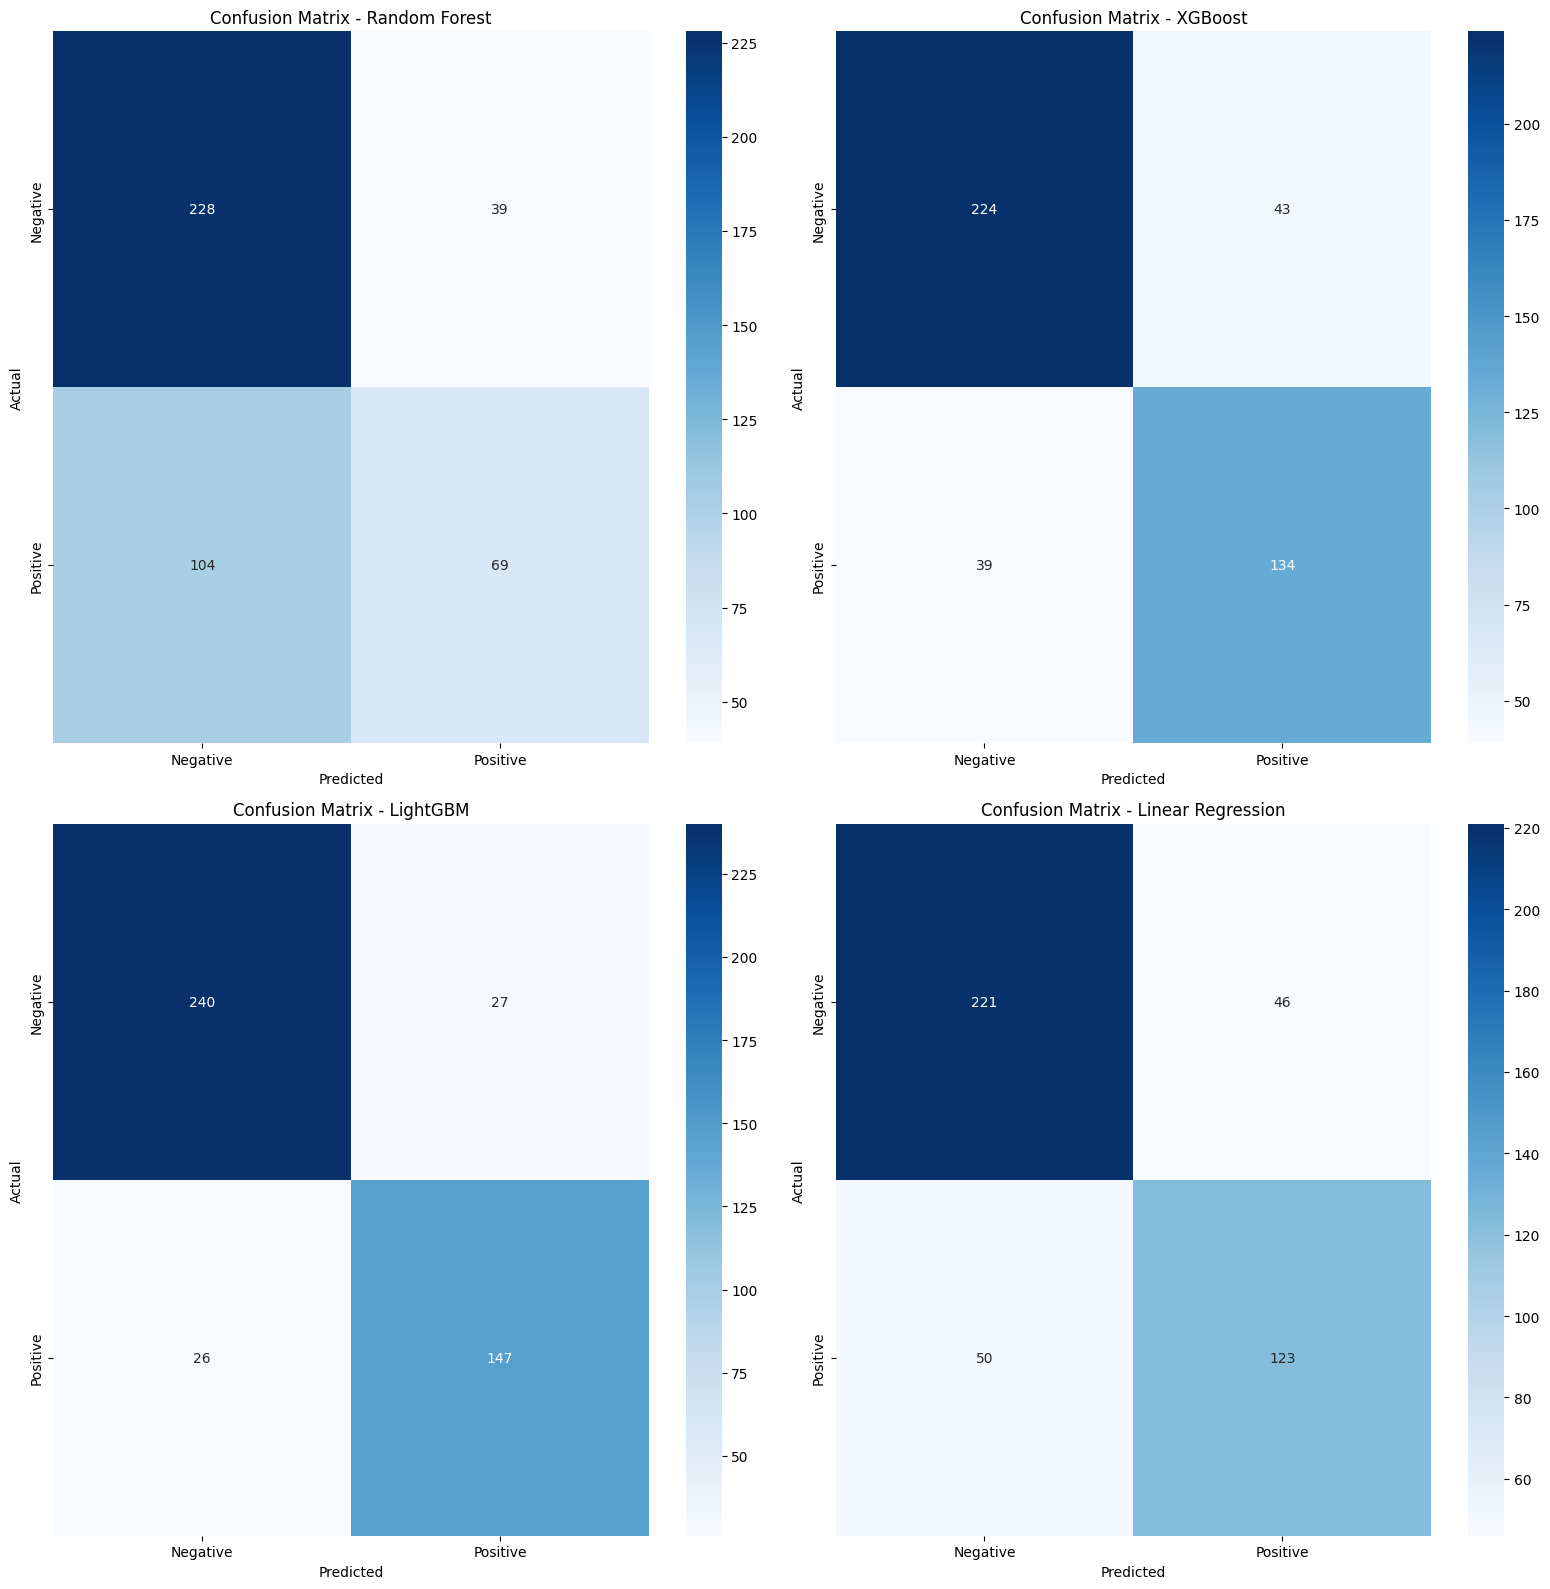

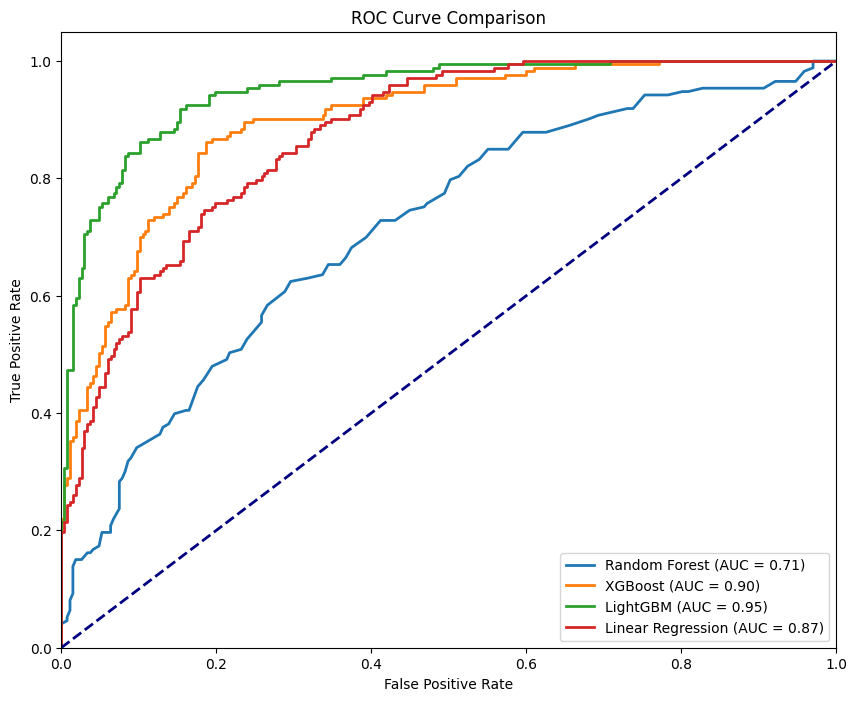

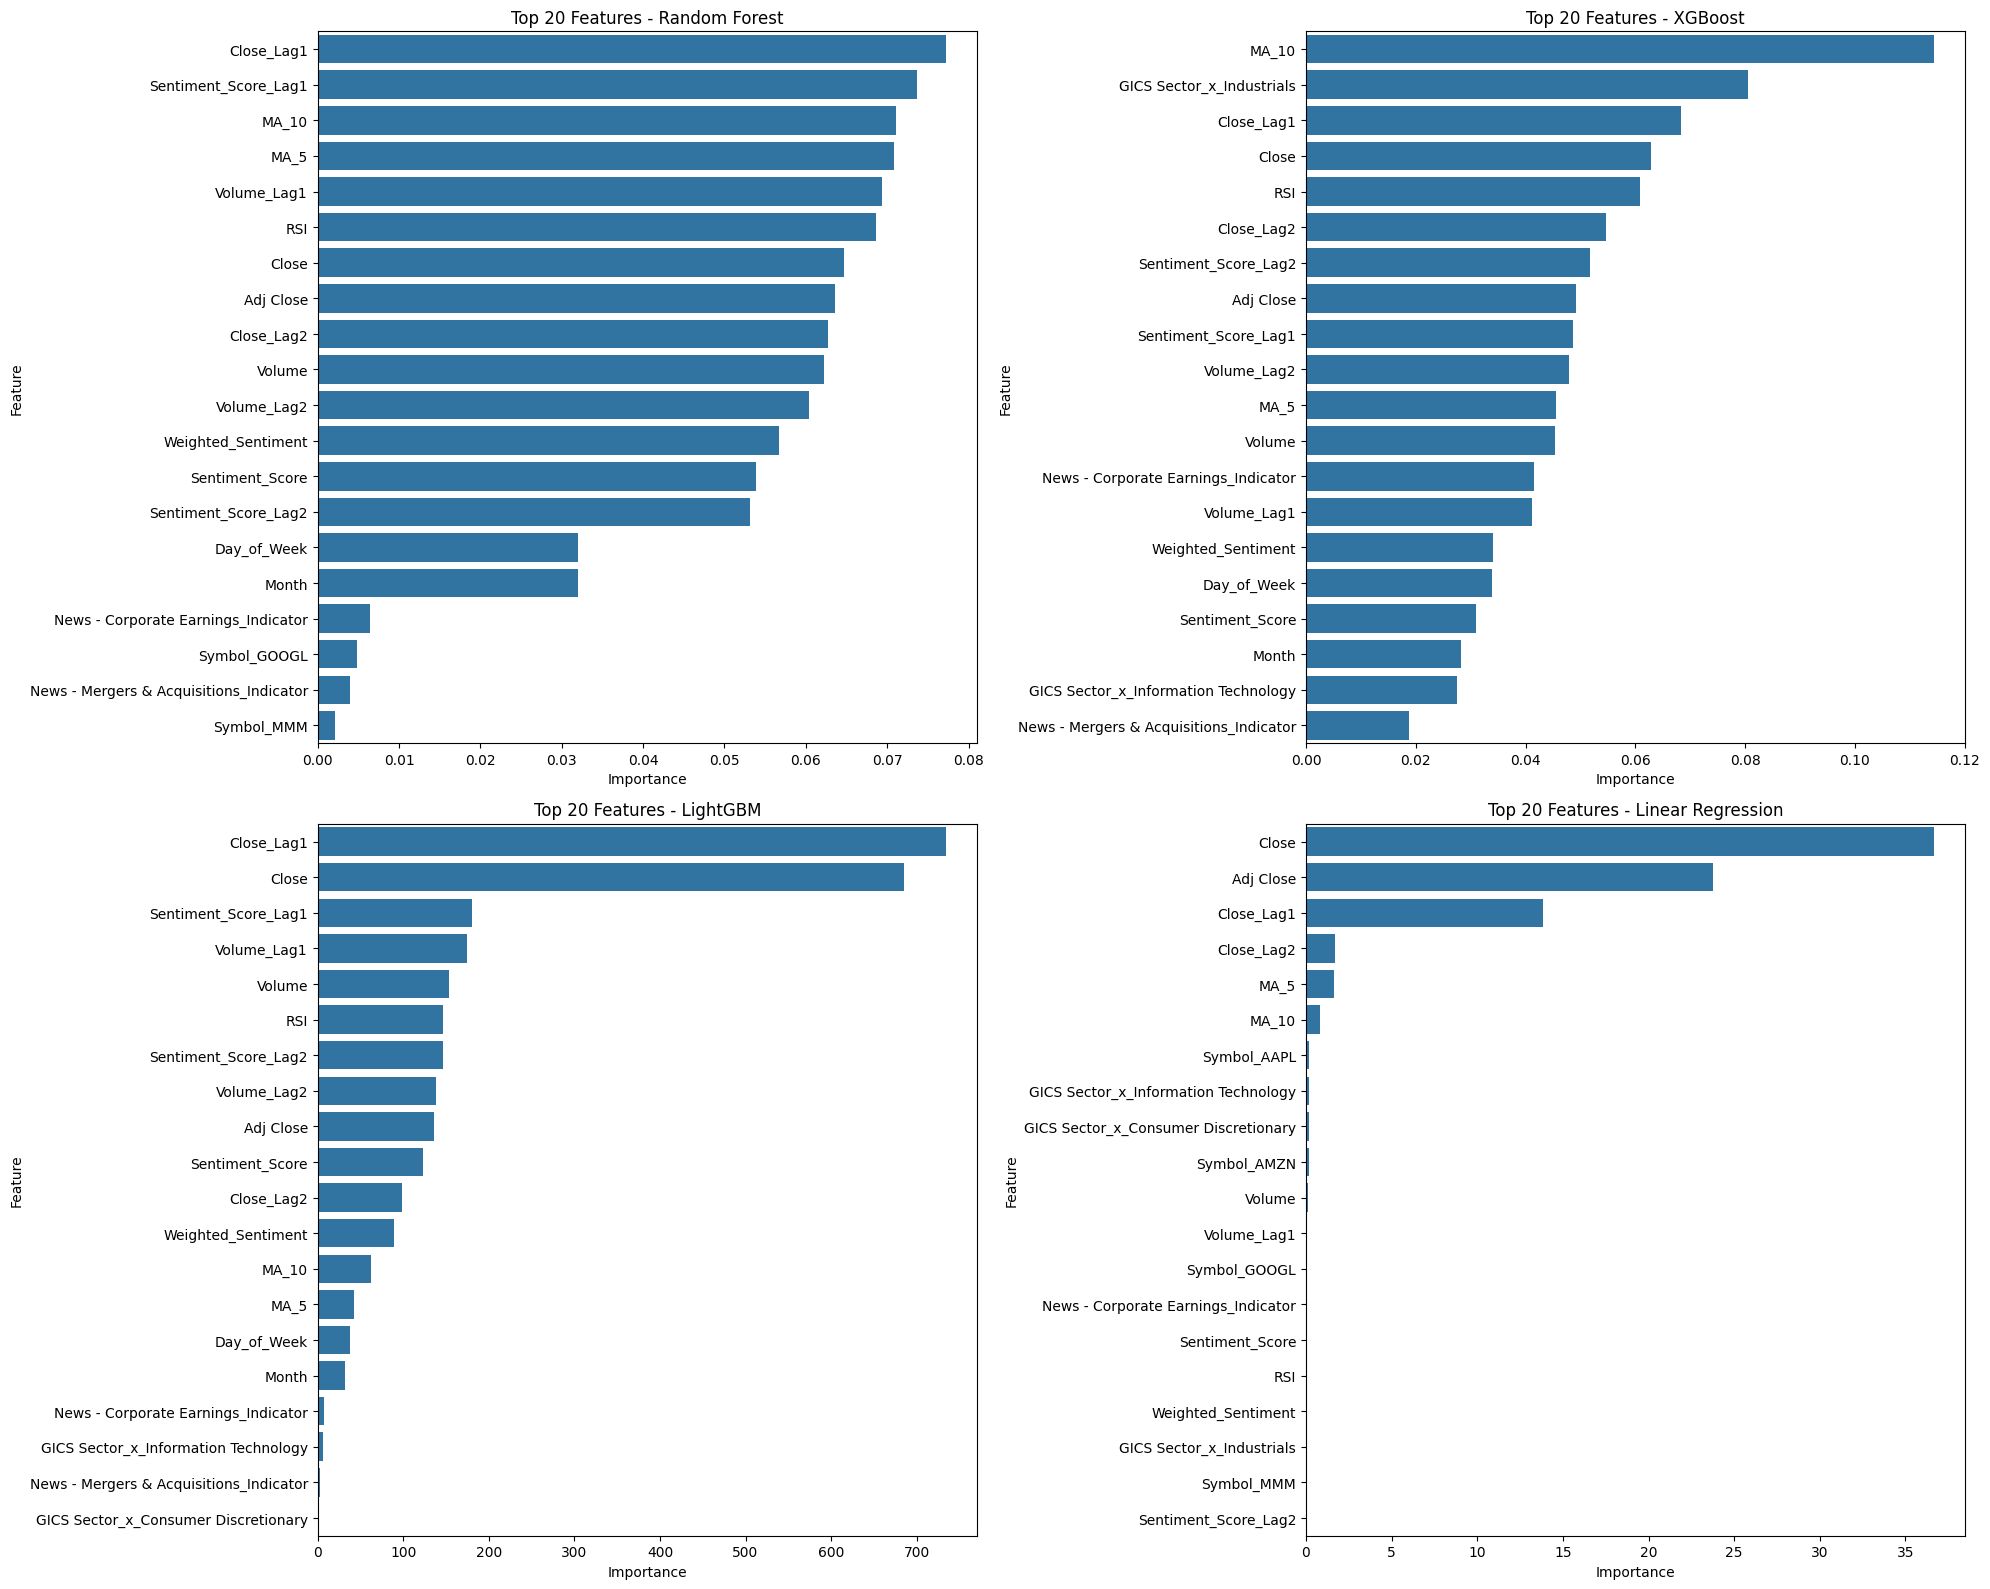


Performance for MMM (RandomForest):
              precision    recall  f1-score   support

           0       0.58      0.98      0.73        46
           1       0.91      0.24      0.38        42

    accuracy                           0.62        88
   macro avg       0.75      0.61      0.55        88
weighted avg       0.74      0.62      0.56        88


Performance for MMM (Linear Regression):
              precision    recall  f1-score   support

           0       0.63      0.87      0.73        46
           1       0.76      0.45      0.57        42

    accuracy                           0.67        88
   macro avg       0.70      0.66      0.65        88
weighted avg       0.69      0.67      0.65        88


Performance for AAPL (RandomForest):
              precision    recall  f1-score   support

           0       0.58      0.58      0.58        43
           1       0.60      0.60      0.60        45

    accuracy                           0.59        88
   macro av

In [21]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split, TimeSeriesSplit, GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix, roc_curve, auc, mean_squared_error, r2_score
from sklearn.linear_model import LinearRegression
from imblearn.over_sampling import SMOTE
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
import seaborn as sns
import matplotlib.pyplot as plt
import shap


rf_param_grid = {
    'n_estimators': [100, 200],
    'max_depth': [None, 20],
    'min_samples_split': [2, 5]
}

# Initialize TimeSeriesSplit
tscv = TimeSeriesSplit(n_splits=3)

# Function to ploting feature importance
def plot_feature_importance(feature_importance_df, model_name, ax):
    sns.barplot(x='importance', y='feature', data=feature_importance_df.head(20), ax=ax)
    ax.set_title(f'Top 20 Features - {model_name}')
    ax.set_xlabel('Importance')
    ax.set_ylabel('Feature')

def plot_all_feature_importances(rf_importance, xgb_importance, lgbm_importance, lr_importance):
    fig, axes = plt.subplots(2, 2, figsize=(20, 16))
    plot_feature_importance(rf_importance, 'Random Forest', axes[0, 0])
    plot_feature_importance(xgb_importance, 'XGBoost', axes[0, 1])
    plot_feature_importance(lgbm_importance, 'LightGBM', axes[1, 0])
    plot_feature_importance(lr_importance, 'Linear Regression', axes[1, 1])
    plt.tight_layout()
    plt.show()

def plot_confusion_matrix(y_true, y_pred, model_name, ax):
    cm = confusion_matrix(y_true, y_pred)
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=['Negative', 'Positive'],
                yticklabels=['Negative', 'Positive'], ax=ax)
    ax.set_title(f'Confusion Matrix - {model_name}')
    ax.set_xlabel('Predicted')
    ax.set_ylabel('Actual')

def plot_all_confusion_matrices(y_true, y_pred_rf, y_pred_xgb, y_pred_lgbm, y_pred_lr):
    fig, axes = plt.subplots(2, 2, figsize=(16, 16))
    plot_confusion_matrix(y_true, y_pred_rf, 'Random Forest', axes[0, 0])
    plot_confusion_matrix(y_true, y_pred_xgb, 'XGBoost', axes[0, 1])
    plot_confusion_matrix(y_true, y_pred_lgbm, 'LightGBM', axes[1, 0])
    plot_confusion_matrix(y_true, y_pred_lr, 'Linear Regression', axes[1, 1])
    plt.tight_layout()
    plt.show()

def plot_model_accuracies(accuracies, model_names):
    plt.figure(figsize=(10, 6))
    bars = plt.bar(model_names, accuracies)
    plt.title('Model Accuracy Comparison')
    plt.xlabel('Models')
    plt.ylabel('Accuracy')
    plt.ylim(0, 1) 

    for bar in bars:
        height = bar.get_height()
        plt.text(bar.get_x() + bar.get_width()/2., height,
                 f'{height:.4f}',
                 ha='center', va='bottom')

    plt.tight_layout()
    plt.show()


def plot_roc_curves(y_true, model_preds, model_names):
    plt.figure(figsize=(10, 8))

    for model_name, y_pred_proba in zip(model_names, model_preds):
        fpr, tpr, _ = roc_curve(y_true, y_pred_proba)
        roc_auc = auc(fpr, tpr)
        plt.plot(fpr, tpr, lw=2, label=f'{model_name} (AUC = {roc_auc:.2f})')

    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC Curve Comparison')
    plt.legend(loc="lower right")
    plt.show()


numeric_columns = data_selected.select_dtypes(include=['float64', 'int64']).columns
correlation_matrix = data_selected[numeric_columns].corr()

plt.figure(figsize=(20, 16))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', linewidths=0.5)
plt.title('Feature Correlation Heatmap')
plt.tight_layout()
plt.show()

# GridSearchCV for RandomForestClassifier
print("Performing GridSearchCV for RandomForestClassifier...")
rf_grid_search = GridSearchCV(RandomForestClassifier(random_state=42), rf_param_grid, cv=tscv, scoring='accuracy', n_jobs=-1)
rf_grid_search.fit(X_train_resampled, y_train_resampled)

print("Best parameters for RandomForestClassifier:")
print(rf_grid_search.best_params_)


y_pred_rf = rf_grid_search.predict(X_test)
rf_probs = rf_grid_search.predict_proba(X_test)[:, 1]
print("\nRandomForest Test Accuracy:", accuracy_score(y_test, y_pred_rf))
print("\nRandomForest Classification Report:")
print(classification_report(y_test, y_pred_rf))


rf_feature_importance = pd.DataFrame({
    'feature': X_train.columns,
    'importance': rf_grid_search.best_estimator_.feature_importances_
}).sort_values('importance', ascending=False)

print("\nRandom Forest - Top 10 Most Important Features:")
print(rf_feature_importance.head(10))
# plot_feature_importance(rf_feature_importance, 'Random Forest')


print("\nTraining XGBoost...")
xgb_model = XGBClassifier(random_state=42, use_label_encoder=False, eval_metric='logloss')
xgb_model.fit(X_train_resampled, y_train_resampled)
y_pred_xgb = xgb_model.predict(X_test)
xgb_probs = xgb_model.predict_proba(X_test)[:, 1]

print("\nXGBoost Test Accuracy:", accuracy_score(y_test, y_pred_xgb))
print("\nXGBoost Classification Report:")
print(classification_report(y_test, y_pred_xgb))

xgb_feature_importance = pd.DataFrame({
    'feature': X_train.columns,
    'importance': xgb_model.feature_importances_
}).sort_values('importance', ascending=False)

print("\nXGBoost - Top 10 Most Important Features:")
print(xgb_feature_importance.head(10))
# plot_feature_importance(xgb_feature_importance, 'XGBoost')



print("\nTraining LightGBM...")
lgbm_model = LGBMClassifier(random_state=42)
lgbm_model.fit(X_train_resampled, y_train_resampled)
y_pred_lgbm = lgbm_model.predict(X_test)
lgbm_probs = lgbm_model.predict_proba(X_test)[:, 1]

print("\nLightGBM Test Accuracy:", accuracy_score(y_test, y_pred_lgbm))
print("\nLightGBM Classification Report:")
print(classification_report(y_test, y_pred_lgbm))

lgbm_feature_importance = pd.DataFrame({
    'feature': X_train.columns,
    'importance': lgbm_model.feature_importances_
}).sort_values('importance', ascending=False)

print("\nLightGBM - Top 10 Most Important Features:")
print(lgbm_feature_importance.head(10))
# plot_feature_importance(lgbm_feature_importance, 'LightGBM')


# Linear Regression
print("\nTraining Linear Regression...")
lr_model = LinearRegression()
lr_model.fit(X_train_resampled, y_train_resampled)

y_pred_lr = lr_model.predict(X_test)
y_pred_lr_class = (y_pred_lr > 0.5).astype(int)

print("\nLinear Regression Test Accuracy:", accuracy_score(y_test, y_pred_lr_class))
print("\nLinear Regression Classification Report:")
print(classification_report(y_test, y_pred_lr_class))
print("\nLinear Regression Mean Squared Error:", mean_squared_error(y_test, y_pred_lr))
print("Linear Regression R-squared Score:", r2_score(y_test, y_pred_lr))


lr_feature_importance = pd.DataFrame({
    'feature': X_train.columns,
    'importance': np.abs(lr_model.coef_)
}).sort_values('importance', ascending=False)

print("\nLinear Regression - Top 10 Most Important Features:")
print(lr_feature_importance.head(10))


rf_accuracy = accuracy_score(y_test, y_pred_rf)
xgb_accuracy = accuracy_score(y_test, y_pred_xgb)
lgbm_accuracy = accuracy_score(y_test, y_pred_lgbm)
lr_accuracy = accuracy_score(y_test, y_pred_lr_class)


accuracies = [rf_accuracy, xgb_accuracy, lgbm_accuracy, lr_accuracy]
model_names = ['Random Forest', 'XGBoost', 'LightGBM', 'Linear Regression']

# PLots the Accuracy of all the models
plot_model_accuracies(accuracies, model_names)

# Plotting all confusion matrices for Random Forest, XGBoost, LightGBM, and Linear Regression 
plot_all_confusion_matrices(y_test, y_pred_rf, y_pred_xgb, y_pred_lgbm, y_pred_lr_class)


# Ploting ROC curves for Random Forest, XGBoost, LightGBM, and Linear Regression
plot_roc_curves(y_test, [rf_probs, xgb_probs, lgbm_probs, y_pred_lr],
                ['Random Forest', 'XGBoost', 'LightGBM', 'Linear Regression'])

# Ploting feature Importance for Random Forest, XGBoost, LightGBM, and Linear Regression
plot_all_feature_importances(rf_feature_importance, xgb_feature_importance,
                             lgbm_feature_importance, lr_feature_importance)

# Performance by stock
for symbol in symbols_to_keep:
    if f'Symbol_{symbol}' in X_test.columns:
        mask = X_test[f'Symbol_{symbol}'] == 1
        if mask.sum() > 0:  # Check if there are any samples for this stock
            print(f"\nPerformance for {symbol} (RandomForest):")
            print(classification_report(y_test[mask], y_pred_rf[mask]))
            print(f"\nPerformance for {symbol} (Linear Regression):")
            print(classification_report(y_test[mask], y_pred_lr_class[mask]))
        else:
            print(f"\nNo samples for {symbol} in the test set.")
    else:
        print(f"\nNo data for {symbol} in the test set.")

# Distribution of stocks in the test set
print("\nDistribution of stocks in the test set:")
for symbol in symbols_to_keep:
    if f'Symbol_{symbol}' in X_test.columns:
        count = X_test[f'Symbol_{symbol}'].sum()
        percentage = (count / len(X_test)) * 100
        print(f"{symbol}: {count} samples ({percentage:.2f}%)")
    else:
        print(f"{symbol}: 0 samples (0.00%)")

In [1]:
!pip install shap

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 540.1/540.1 kB 29.4 MB/s eta 0:00:00
